# TESS search

```{warning}
Under construction
```

In this tutorial we use nuance to search for the known planetary companion [TOI-540 b](https://exofop.ipac.caltech.edu/tess/target.php?id=200322593)

```{note}
This tutorial requires the `lightkurve` package to access the data
```

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## Download

We start by downloading the data using the `lightkurve` package

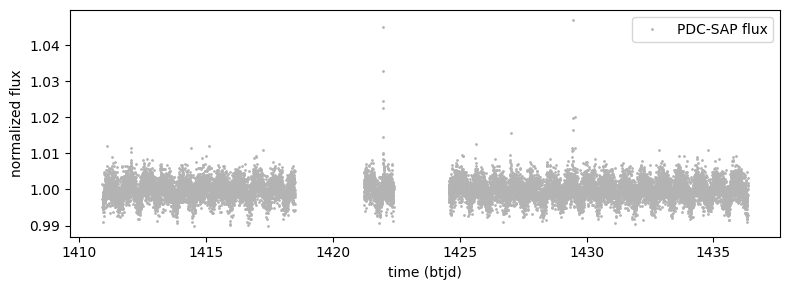

In [2]:
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("TOI 540", author="SPOC", exptime=120)[0].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

# plot
plt.figure(figsize=(8, 3))
plt.plot(time, flux, ".", c="0.7", ms=2, label="PDC-SAP flux")
plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

For this tutorial we decided to focus on a single sector, but searching and combining different TESS sectors can be done following the approach presented in the [ground-based search tutorial](./ground_based.ipynb).

## GP kernel optimization

Nest step is to define and optimize the GP kernel that will help model the covariance of the data, especially stellar variability. Here, we will use a mixture of two SHO kernels, implemented in `nuance.kernels` and representative of a wide range of stellar variability signals.

In [3]:
import jax

jax.config.update("jax_enable_x64", True)

from nuance import Nuance
from nuance.kernels import rotation

# rotation period from literature or Lomb-Scargle
star_period = 0.7252520593120725

# building a Nuance object
nu = Nuance(time, flux, error.mean())

# building the default rotation GP (provided by Nuance)
build_gp, init = rotation(star_period, error.mean(), long_scale=0.5)
optimize, mu, nll = nu.gp_optimization(build_gp)

# optimization
gp_params = optimize(
    init, ["log_sigma", "log_short_scale", "log_short_sigma", "log_long_sigma"]
)
gp_params = optimize(gp_params)

ScipyMinimizeInfo(fun_val=Array(-66213.93588932, dtype=float64, weak_type=True), success=True, status=0, iter_num=16, hess_inv=Array([[ 8.30388760e-03, -3.62525461e-02, -1.48637315e-02,
        -9.56907986e-05],
       [-3.62525461e-02,  4.22357237e-01,  1.74987213e-01,
         3.72217108e-04],
       [-1.48637315e-02,  1.74987213e-01,  7.26880971e-02,
         1.51564936e-04],
       [-9.56907986e-05,  3.72217108e-04,  1.51564936e-04,
         4.80102329e-03]], dtype=float64), num_fun_eval=Array(28, dtype=int32), num_jac_eval=Array(28, dtype=int32), num_hess_eval=Array(0, dtype=int32))
ScipyMinimizeInfo(fun_val=Array(-66241.48990017, dtype=float64, weak_type=True), success=True, status=0, iter_num=86, hess_inv=Array([[ 1.17052493e+08,  1.03197068e+08,  4.79950205e+05,
         1.03581567e-01,  2.92011960e+00, -1.09655083e-02,
         0.00000000e+00, -1.13915045e-01,  5.84062696e+07],
       [ 1.03197069e+08,  9.09817022e+07,  4.23138214e+05,
         9.15315382e-02,  2.56473696e+00,

## Flare masking

As flares and other astrophysical signals are not part of our model, we need to mask them. We do that using the `nuance.Nuance.mask_flares` function, that iteratively mask flares using a sigma clipping approach around the mean of the GP model

In [4]:
nu_cleaned = nu.mask_flares(build_gp, gp_params, sigma=4.0)

ScipyMinimizeInfo(fun_val=Array(-65956.33175846, dtype=float64, weak_type=True), success=True, status=0, iter_num=15, hess_inv=Array([[ 8.10930533e-01, -3.35111820e-03,  1.73959613e-02,
         2.42119137e-05,  1.13416703e-03,  1.05207667e-06,
         0.00000000e+00, -3.53138820e-11,  3.84845897e-01],
       [-3.35111820e-03,  9.99319627e-01, -2.04977803e-02,
        -3.30085103e-05, -1.47666603e-03, -1.31705818e-06,
         0.00000000e+00, -2.18499345e-10,  8.05959803e-03],
       [ 1.73959613e-02, -2.04977803e-02,  4.99465666e-01,
         3.86077772e-05, -4.85582534e-04,  8.49953287e-07,
         0.00000000e+00,  1.99414128e-10,  6.13886760e-03],
       [ 2.42119137e-05, -3.30085103e-05,  3.86077772e-05,
         3.49088340e-05, -1.33535877e-04, -4.49833098e-08,
         0.00000000e+00, -1.06004390e-09,  1.73239885e-05],
       [ 1.13416703e-03, -1.47666603e-03, -4.85582534e-04,
        -1.33535877e-04,  1.49613128e-02,  4.39805869e-06,
         0.00000000e+00,  4.68465885e-10,  

Let's see the cleaned light curve

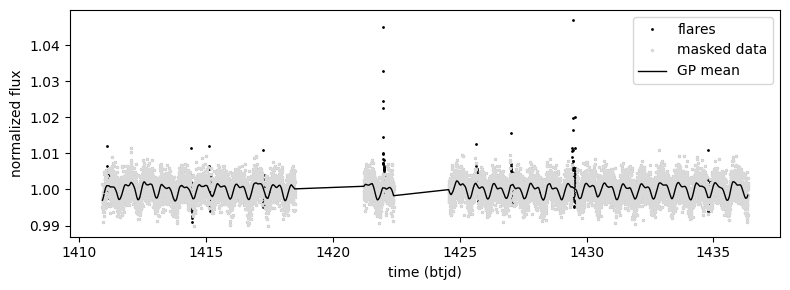

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(nu.time, nu.flux, ".", c="k", ms=2, label="flares")
plt.plot(nu_cleaned.time, nu_cleaned.flux, ".", c="0.85", ms=3, label="masked data")

gp_mean = nu_cleaned.mu(None)
split_idxs = [
    0,
    *np.flatnonzero(np.diff(time) > 10 / 60 / 24),
    len(time),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = nu_cleaned.time[split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if _ else None, lw=1)
    _ = False

plt.xlabel("time (btjd)")
plt.ylabel("normalized flux")
plt.legend()
plt.tight_layout()

## Transit search

All the above is data preparation, now is time to actually search the cleaned light curve

### Linear search

As usual, we start by defining a duration and epoch grid, and run the linear search

In [6]:
t0s = time.copy()
durations = np.linspace(10 / 60 / 24, 2 / 24, 8)

gp = build_gp(gp_params, time)
nu = Nuance(time, flux, gp=gp)
nu.linear_search(t0s, durations)

  0%|          | 0/1215 [00:00<?, ?it/s]

### Periodic search

We can then define an optimal period grid following [Ofir (2014)](https://ui.adsabs.harvard.edu/abs/2014A%26A...561A.138O/abstract) (Eq. 7)

In [7]:
from nuance import Star

star = Star(radius=0.189, mass=0.159)
periods = star.period_grid(nu.time_span, oversampling=5)

and run the periodic search

In [8]:
search = nu.periodic_search(periods)

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.11/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/11745 [00:00<?, ?it/s]

### Result

We can retrieve the best (maximum-SNR) transit parameters with

In [9]:
t0, D, P = search.best
snr = nu.snr(t0, D, P)
depth, depth_error = nu.depth(t0, D, P)

print("\tExoFOP\tnuance")
print(f"period\t1.23915\t{P:.5f}")
print(f"durat.\t{2318.65*1e-6:.5f}\t{depth:.5f}\t days")
print(f"depth\t{0.4887/24:.5f}\t{D:.5f}\t days")
print(f"snr\t17.9\t{snr:.1f}")
print(f"sectors\t5\t1")

	ExoFOP	nuance
period	1.23915	1.23916
durat.	0.00232	0.00185	 days
depth	0.02036	0.01786	 days
snr	17.9	8.8
sectors	5	1


and plot the periodogram and phase-folded light curve with

Text(0.0, 1.0, 'Phase-folded detrended light curve')

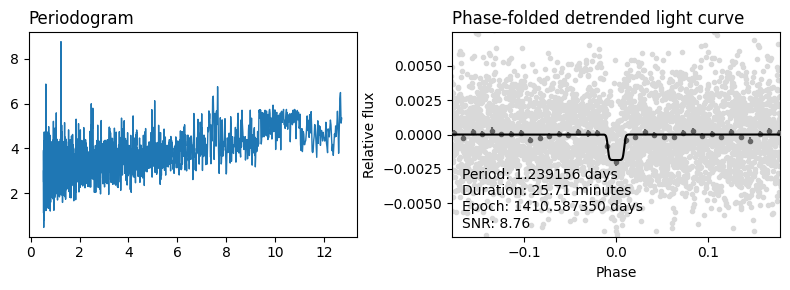

In [10]:
from nuance.utils import phase, binn_time

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(periods, search.Q_snr, lw=1)
plt.title("Periodogram", loc="left")

plt.subplot(122)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.time, t0, P)

detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".85")
bx, by, be = binn_time(phi, detrended, bins=15 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="0.4", zorder=10)
plt.xlim(*(np.array([-1, 1]) * 10 * D))
plt.ylim(*(np.array([-1, 1]) * float(np.abs(astro.min())) * 4))
_ = np.argsort(phi)
plt.plot(phi[_], astro[_], c="k", zorder=20)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.text(
    0.03,
    0.03,
    f"Period: {P:.6f} days\nDuration: {D* 24 * 60:.2f} minutes\nEpoch: {t0:.6f} days\nSNR: {snr:.2f}",
    ha="left",
    va="bottom",
    transform=plt.gca().transAxes,
)
plt.tight_layout()
plt.title("Phase-folded detrended light curve", loc="left")